In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import pandas as pd
from datasets import load_dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
from transformers import GPT2Tokenizer, GPT2Model
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [17]:
class ToxicCommentDataset(Dataset):
    def __init__(self, split = 'train', tokenizer=None, max_length=512):
        jigsaw_path = "julian3833/jigsaw-toxic-comment-classification-challenge"
        self.split = split
        self.tokenizer = tokenizer
        self.max_length = max_length

        if self.split == 'train':
            self.data = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, jigsaw_path, 'train.csv')

        else:
            jigsaw_test = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, jigsaw_path, 'test.csv')
            jigsaw_test_labels = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, jigsaw_path, 'test_labels.csv')
        
            self.data = pd.merge(jigsaw_test, jigsaw_test_labels, on='id')
            self.data = self.data[self.data['toxic'] != -1]

        self.data['label'] = (self.data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) > 0).astype(int)

        ##Equalize the number of positive and negative samples
        num_toxic_samples = self.data['label'].sum()
        toxic_samples = self.data[self.data['label'] == 1]
        non_toxic_samples = self.data[self.data['label'] == 0].sample(num_toxic_samples, random_state=42)
        self.data = pd.concat([toxic_samples, non_toxic_samples]).sample(frac=1, random_state=42).reset_index(drop=True)
            
        self.data.drop(columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate'], inplace=True)
        self.data = self.data.reset_index(drop=True)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['comment_text']
        label = self.data.iloc[idx]['label']
        
        if self.tokenizer:
            encoding = self.tokenizer(
                text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'label': torch.tensor(label, dtype=torch.long)
            }
        
        return text, label

In [18]:
##examine number of samples and label distribution of train and test dataset
train_toxic_dataset = ToxicCommentDataset(split = 'train')
test_toxic_dataset = ToxicCommentDataset(split = 'test')


In [19]:
class GPT2Activations:
    def __init__(self, model = 'gpt2-large', max_length=256):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.tokenizer = GPT2Tokenizer.from_pretrained(model, max_length = max_length, padding='max_length', truncation=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = GPT2Model.from_pretrained(model, 
                                               output_hidden_states=True).to(self.device)
        self.model.eval()

        self.num_layers = self.model.config.n_layer + 1  # Including embeddings
        self.h_size = self.model.config.n_embd

        print(f"Now using GPT-2 ({model}) model with the following configuration:")
        print(f"Number of layers (including embeddings): {self.num_layers}")
        print(f"Hidden size: {self.h_size}")

    def print_activation_shapes(self, text = "Text to see output shapes"):
        inputs = self.tokenizer(text, return_tensors='pt', max_length=self.tokenizer.model_max_length, padding='max_length', truncation=True).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        hidden_states = outputs.hidden_states
        
        attention_mask = inputs['attention_mask']
    
        print("Activation shapes after mean pooling:")
        for i, hidden_state in enumerate(hidden_states):
            pooled = self.mean_pool_activations(hidden_state, attention_mask)
            if i == 0:
                print(f"Embeddings (pooled): {pooled.shape}")
            else:
                print(f"Layer {i-1} (pooled): {pooled.shape}")

    def extract_activations(self, input_ids, attention_mask):

        with torch.no_grad():
            model_outputs = self.model(input_ids = input_ids.to(self.device), 
                                       attention_mask = attention_mask.to(self.device))
            
            all_hidden_states = model_outputs.hidden_states

            activation_dict = {}
            
            for layer_idx, curr_hidden_state in enumerate(all_hidden_states):
            
                ##pooling to go from (batch_size, seq_len, h_size) to (batch_size, h_size)

                pooled_activations = self.mean_pool_activations(curr_hidden_state, attention_mask)
                activation_dict[f'layer_{layer_idx}_pooled'] = pooled_activations
            
            return activation_dict
        
    def mean_pool_activations(self, hidden_states, attention_mask):
        
        ## function to mean pool the activations based on the mask
        ##masked/padded tokens will not contribute to the mean

        attention_mask = attention_mask.to(hidden_states.device)  # Ensure same device
        expanded_mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
        masked_hidden_states = hidden_states * expanded_mask
        sum_hidden_states = torch.sum(masked_hidden_states, dim=1)
        sum_mask = torch.clamp(expanded_mask.sum(dim=1), min=1e-9)
        mean_pooled = sum_hidden_states / sum_mask
        return mean_pooled
        


activations = GPT2Activations()


text = "This is a sample comment"
print('\n\n\n')
activations.print_activation_shapes(text)

Now using GPT-2 (gpt2-large) model with the following configuration:
Number of layers (including embeddings): 37
Hidden size: 1280




Activation shapes after mean pooling:
Embeddings (pooled): torch.Size([1, 1280])
Layer 0 (pooled): torch.Size([1, 1280])
Layer 1 (pooled): torch.Size([1, 1280])
Layer 2 (pooled): torch.Size([1, 1280])
Layer 3 (pooled): torch.Size([1, 1280])
Layer 4 (pooled): torch.Size([1, 1280])
Layer 5 (pooled): torch.Size([1, 1280])
Layer 6 (pooled): torch.Size([1, 1280])
Layer 7 (pooled): torch.Size([1, 1280])
Layer 8 (pooled): torch.Size([1, 1280])
Layer 9 (pooled): torch.Size([1, 1280])
Layer 10 (pooled): torch.Size([1, 1280])
Layer 11 (pooled): torch.Size([1, 1280])
Layer 12 (pooled): torch.Size([1, 1280])
Layer 13 (pooled): torch.Size([1, 1280])
Layer 14 (pooled): torch.Size([1, 1280])
Layer 15 (pooled): torch.Size([1, 1280])
Layer 16 (pooled): torch.Size([1, 1280])
Layer 17 (pooled): torch.Size([1, 1280])
Layer 18 (pooled): torch.Size([1, 1280])
Layer 19 (poole

In [20]:
class HarmfulDetectorMLP(nn.Module):
    def __init__(self, input_size, num_classes=1, dropout_rate=0.7):  # Increased dropout
        super(HarmfulDetectorMLP, self).__init__()
        hidden_size = input_size // 4  # Reduce capacity
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [21]:
def save_activations(extractor, dataloader, save_path, split_name):
    
    os.makedirs(save_path, exist_ok=True)
    all_activations = {f'layer_{i}_pooled': [] for i in range(extractor.num_layers)}
    all_labels = []

    for batch in tqdm(dataloader):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label'].numpy()
        
        activations = extractor.extract_activations(input_ids, attention_mask)
        
        for layer_key, layer_activations in activations.items():
            all_activations[layer_key].append(layer_activations)
        
        all_labels.append(labels)
    
    print("Saving to activations disk..")
    for layer_key in all_activations.keys():
        layer_activations = torch.cat(all_activations[layer_key], dim=0).cpu().numpy()
        np.save(os.path.join(save_path, f'{split_name}_{layer_key}_activations.npy'), layer_activations)
    all_labels = np.concatenate(all_labels, axis=0)
    np.save(os.path.join(save_path, f'{split_name}_labels.npy'), all_labels)
    print("Saving completed.")

In [22]:
def train_mlp(layer_idx, activation_path, mlp_paths, num_epochs=10, batch_size=128, learning_rate=0.001):
    train_activations = np.load(os.path.join(activation_path, f'train_layer_{layer_idx}_pooled_activations.npy'))
    train_labels = np.load(os.path.join(activation_path, f'train_labels.npy'))

    test_activations = np.load(os.path.join(activation_path, f'test_layer_{layer_idx}_pooled_activations.npy'))
    test_labels = np.load(os.path.join(activation_path, f'test_labels.npy'))

    train_dataset = TensorDataset(torch.tensor(train_activations, dtype=torch.float32),
                                  torch.tensor(train_labels, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(test_activations, dtype=torch.float32),
                                 torch.tensor(test_labels, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = HarmfulDetectorMLP(input_size=train_activations.shape[1]).to(activations.device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(activations.device), labels.to(activations.device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Calculate val loss (using test as val)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(activations.device), labels.to(activations.device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Evaluate on train
    model.eval()
    train_loss = 0
    train_preds = []
    train_true = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(activations.device), labels.to(activations.device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_preds.extend(preds.cpu().numpy().flatten())
            train_true.extend(labels.cpu().numpy().flatten())
    avg_train_loss_final = train_loss / len(train_loader)
    train_f1 = f1_score(train_true, train_preds)

    # Evaluate on test
    test_loss = 0
    test_preds = []
    test_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(activations.device), labels.to(activations.device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = (outputs > 0.5).float()
            test_preds.extend(preds.cpu().numpy().flatten())
            test_true.extend(labels.cpu().numpy().flatten())
    avg_test_loss = test_loss / len(test_loader)
    test_f1 = f1_score(test_true, test_preds)

    print(f'Train Loss: {avg_train_loss_final:.4f}, Train F1: {train_f1:.4f}')
    print(f'Test Loss: {avg_test_loss:.4f}, Test F1: {test_f1:.4f}')

    torch.save(model.state_dict(), os.path.join(mlp_paths, f'mlp_layer_{layer_idx}_model.pth'))

    return {
        'train_loss': avg_train_loss_final,
        'train_f1': train_f1,
        'test_loss': avg_test_loss,
        'test_f1': test_f1,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history
    }


In [ ]:
def main():
    # Configuration
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH_SIZE = 64  # For activation extraction
    MAX_LENGTH = 128  # Token limit for GPT-2
    SAVE_DIR = os.path.join('/home/anwesh/scratch/layers-to-latents', 'gpt2_activations')
    
    # Initialize extractor
    extractor = GPT2Activations()
    
    # Create datasets
    train_dataset = ToxicCommentDataset(
        split='train',
        tokenizer=extractor.tokenizer,
        max_length=MAX_LENGTH
    )
    
    test_dataset = ToxicCommentDataset(
        split='test',
        tokenizer=extractor.tokenizer,
        max_length=MAX_LENGTH
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Extract activations (do this once and save)
    print("="*60)
    print("STEP 1: Extracting Activations")
    print("="*60)
    
    # Check if activations are already saved
    train_labels_path = os.path.join(SAVE_DIR, 'train_labels.npy')
    test_labels_path = os.path.join(SAVE_DIR, 'test_labels.npy')
    
    if os.path.exists(train_labels_path) and os.path.exists(test_labels_path):
        print("Activations already exist. Skipping extraction.")
    else:
        save_activations(extractor, train_loader, SAVE_DIR, split_name='train')
        save_activations(extractor, test_loader, SAVE_DIR, split_name='test')
    
    # Train MLPs for each layer
    print("\n" + "="*60)
    print("STEP 2: Training Layer-wise MLPs")
    print("="*60)
    
    results = {}
    loss_histories = {}
    
    for layer_idx in range(extractor.num_layers - 20):
        if layer_idx == 0:
            print("Training on embedding layer")
        else:
            print(f"Training on transformer layer: {layer_idx - 1}")

        metrics = train_mlp(
            layer_idx=layer_idx,
            activation_path=SAVE_DIR,
            mlp_paths=SAVE_DIR,
            num_epochs=5,
            batch_size=BATCH_SIZE,
            learning_rate=0.0001
        )
        
        results[layer_idx] = metrics['test_f1']
        loss_histories[layer_idx] = {
            'train': metrics['train_loss_history'],
            'val': metrics['val_loss_history']
        }

        print("\n\n\n\n\n")
    
    # Print summary
    print("\n" + "="*60)
    print("LAYER-WISE PERFORMANCE SUMMARY")
    print("="*60)
    for layer_idx, acc in results.items():
        layer_name = "Embeddings" if layer_idx == 0 else f"Transformer Layer {layer_idx}"
        print(f"{layer_name:30s} | F1: {acc:.4f}")
    
    # Plot loss curves in a grid
    num_layers = len(loss_histories)
    cols = 8  # Increase columns for wider, shorter plots
    rows = (num_layers + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(24, 12))  # Adjust figsize for better aspect ratio
    axes = axes.flatten()
    
    for idx, layer_idx in enumerate(loss_histories):
        ax = axes[idx]
        train_losses = loss_histories[layer_idx]['train']
        val_losses = loss_histories[layer_idx]['val']
        epochs = range(1, len(train_losses) + 1)
        
        ax.plot(epochs, train_losses, label='Train Loss', marker='o')
        ax.plot(epochs, val_losses, label='Val Loss', marker='o')
        ax.set_title(f'Layer {layer_idx} ({"Embeddings" if layer_idx == 0 else f"Transformer {layer_idx}"})')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_ylim(0, 1)  # Fix y-axis range to [0, 1]
        ax.legend()
        ax.grid(True)
    
    # Hide unused subplots
    for idx in range(num_layers, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

Now using GPT-2 (gpt2-large) model with the following configuration:
Number of layers (including embeddings): 37
Hidden size: 1280
STEP 1: Extracting Activations
Activations already exist. Skipping extraction.

STEP 2: Training Layer-wise MLPs
Training on embedding layer
STEP 1: Extracting Activations
Activations already exist. Skipping extraction.

STEP 2: Training Layer-wise MLPs
Training on embedding layer
Epoch [1/5], Train Loss: 0.3531, Val Loss: 0.3275
Epoch [1/5], Train Loss: 0.3531, Val Loss: 0.3275
Epoch [2/5], Train Loss: 0.2719, Val Loss: 0.3155
Epoch [2/5], Train Loss: 0.2719, Val Loss: 0.3155
Epoch [3/5], Train Loss: 0.2560, Val Loss: 0.3192
Epoch [3/5], Train Loss: 0.2560, Val Loss: 0.3192
Epoch [4/5], Train Loss: 0.2479, Val Loss: 0.3123
Epoch [4/5], Train Loss: 0.2479, Val Loss: 0.3123
Epoch [5/5], Train Loss: 0.2382, Val Loss: 0.3282
Epoch [5/5], Train Loss: 0.2382, Val Loss: 0.3282
Train Loss: 0.1993, Train F1: 0.9210
Test Loss: 0.3282, Test F1: 0.8773






Training 

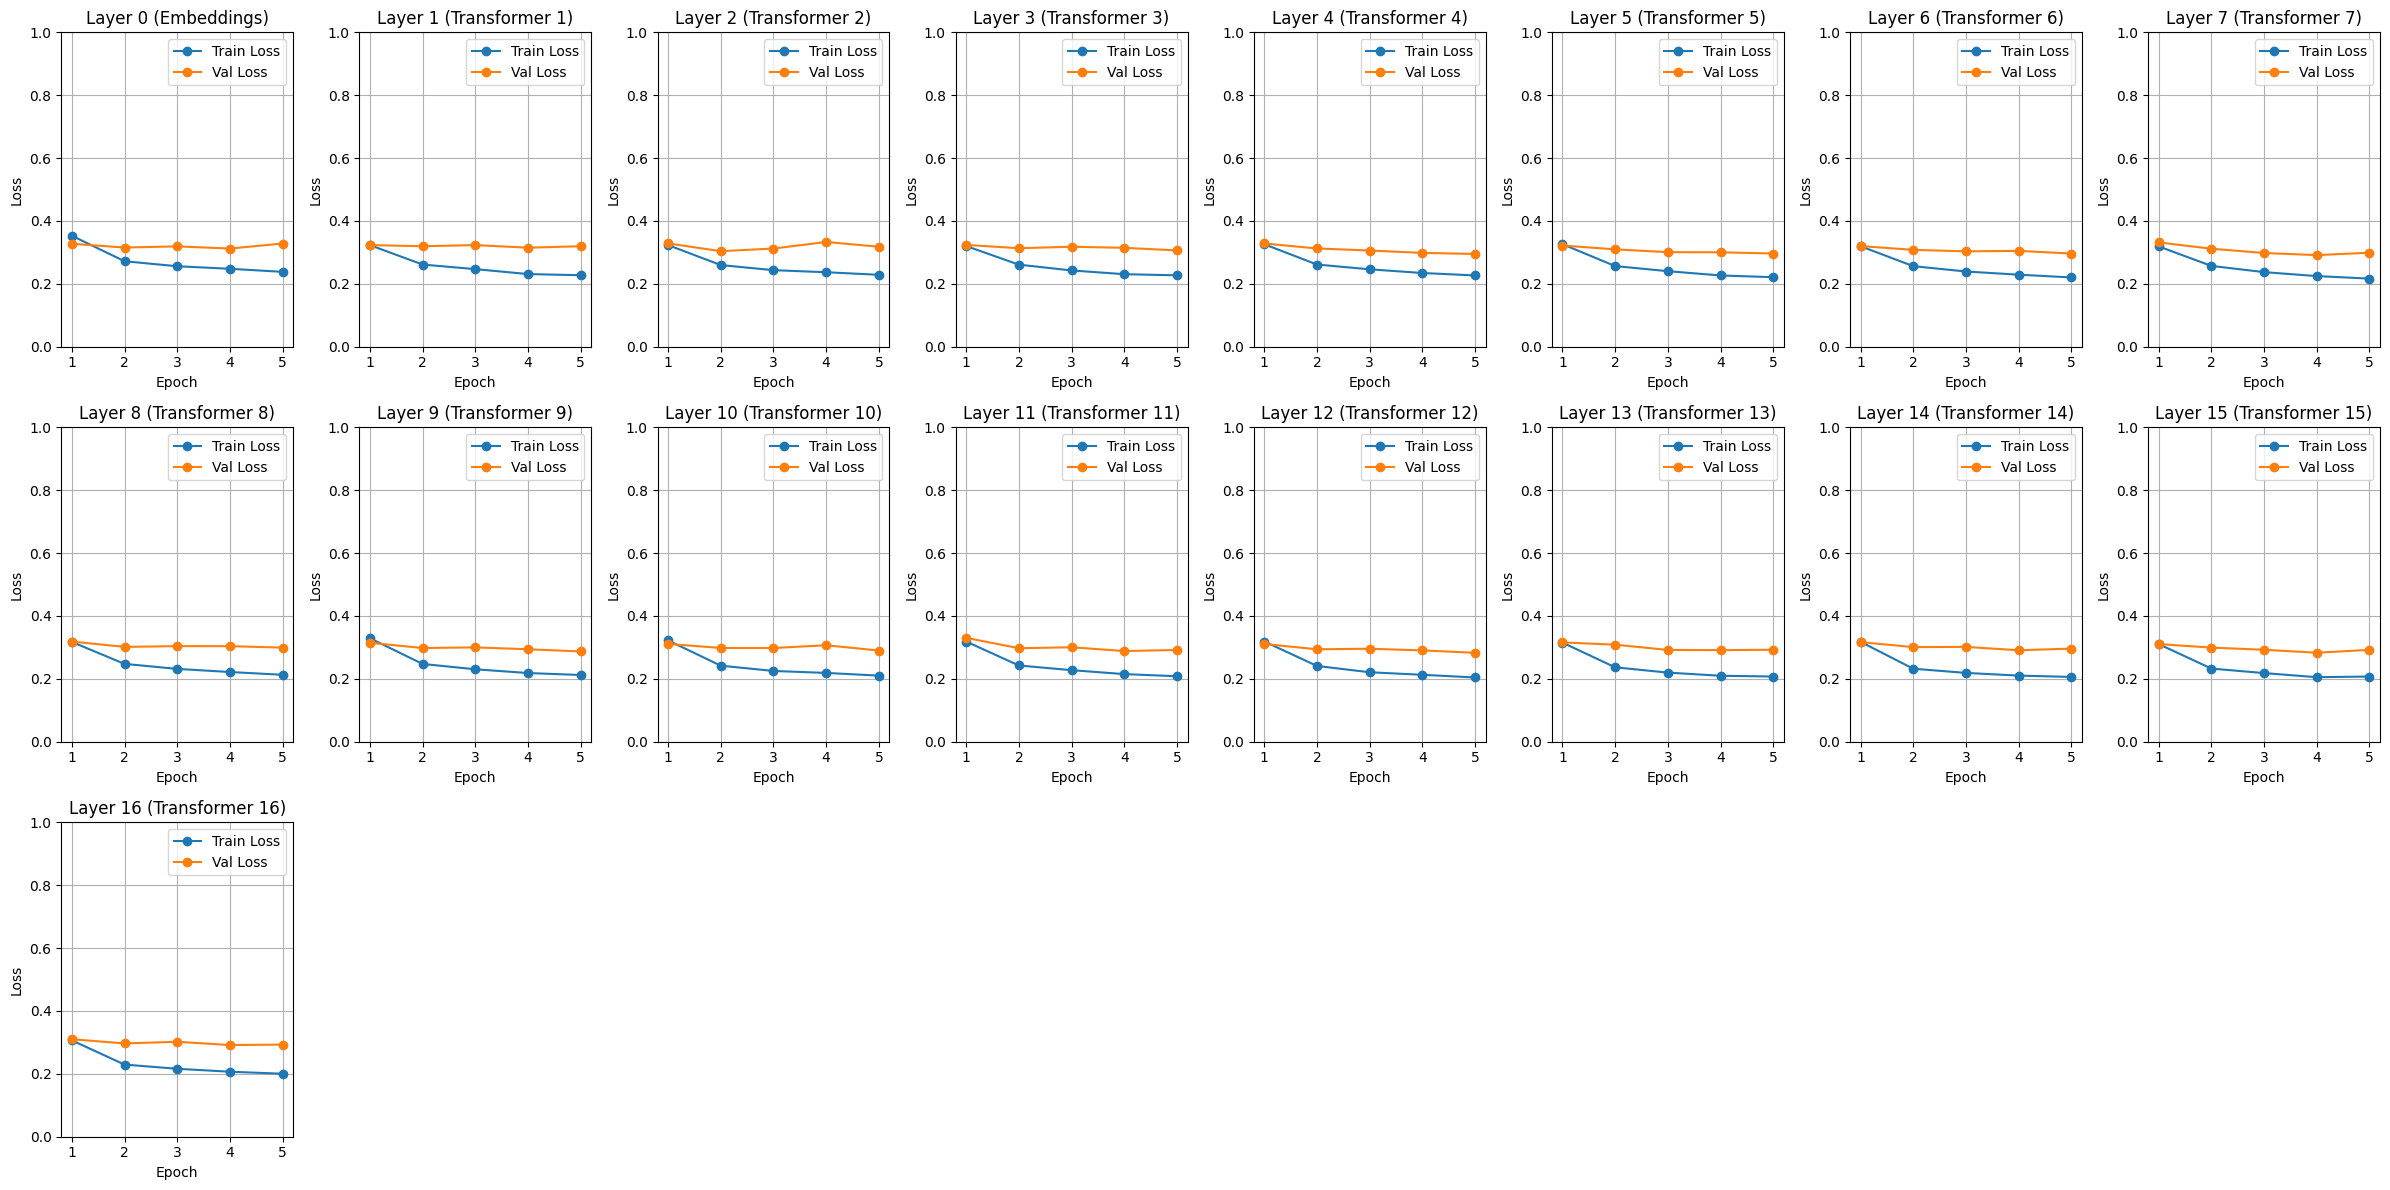

In [29]:
main()